In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from actler.model import ALModel
from actler.data import generate_rosen_data, make_dataloaders, DataLoader, SampleDataset
from actler.sampler import random_sampling, mcdue_sampling
from actler.loss import RMSELoss
from actler.train_al import train_model, test_model, active_train_model

In [5]:
X, y = generate_rosen_data(1000, 2)
X_m, y_m, Xi, Xj, Y = generate_rosen_data(100, 2, True)

In [6]:
dataloaders = make_dataloaders(X, y)
dataloaders['Mesh'] = DataLoader(SampleDataset(X_m, y_m))

In [29]:
layers = [2, 8]
net = ALModel(layers)
criterion = RMSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=5e-3)

params = {
    'model': net,
    'criterion': criterion,
    'dataloaders': dataloaders,
    'optimizer': optimizer,
    'n_epochs': 1000
}

In [30]:
net

ALModel(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): ConstDropout(p=0.05)
    (3): Linear(in_features=8, out_features=1, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
  )
)

In [31]:
y_pred = []
for i in range(10):
    y_pred.append(test_model(net, dataloaders['Mesh'], return_pred=True, freeze_mask=True))

Testing model: 100%|██████████| 2.50k/2.50k [00:00<00:00, 3.52kit/s]
Testing model: 100%|██████████| 2.50k/2.50k [00:01<00:00, 1.46kit/s]
Testing model: 100%|██████████| 2.50k/2.50k [00:00<00:00, 4.49kit/s]
Testing model: 100%|██████████| 2.50k/2.50k [00:01<00:00, 2.24kit/s]
Testing model: 100%|██████████| 2.50k/2.50k [00:01<00:00, 2.03kit/s]
Testing model: 100%|██████████| 2.50k/2.50k [00:01<00:00, 1.48kit/s]
Testing model: 100%|██████████| 2.50k/2.50k [00:02<00:00, 1.17kit/s]
Testing model: 100%|██████████| 2.50k/2.50k [00:01<00:00, 1.73kit/s]
Testing model: 100%|██████████| 2.50k/2.50k [00:01<00:00, 1.28kit/s]
Testing model: 100%|██████████| 2.50k/2.50k [00:00<00:00, 3.64kit/s]


In [32]:
STD = np.std(y_pred, axis=0).reshape(Xi.shape)

In [ ]:
plt.figure(figsize=(10, 8))

cp = plt.contourf(Xi, Xj, Y)
plt.colorbar(cp)

X = np.array((dataloaders['Val'].dataset.X.tolist()))
plt.scatter(X.T[0], X.T[1], s=50, edgecolors='k', facecolors='w')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))

cp = plt.contourf(Xi, Xj, STD)
plt.colorbar(cp)

dataloaders['TrainPool'].set_mode('pool')
X = np.array((dataloaders['TrainPool'].dataset.X.tolist()))[dataloaders['TrainPool'].dataset.indexes]
dataloaders['TrainPool'].set_mode('train')
plt.scatter(X.T[1], X.T[0], s=50, edgecolors='k', facecolors='w')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.show()

In [35]:
net, logs = train_model(**params)

--------------------
Training complete in 0 mins 33 seconds with 1000 epoch


Testing model: 100%|██████████| 100/100 [00:00<00:00, 9060.93it/s]


In [36]:
logs['test']

[[15.393216072699571, 11.563278884340365, 52.9079384803772]]

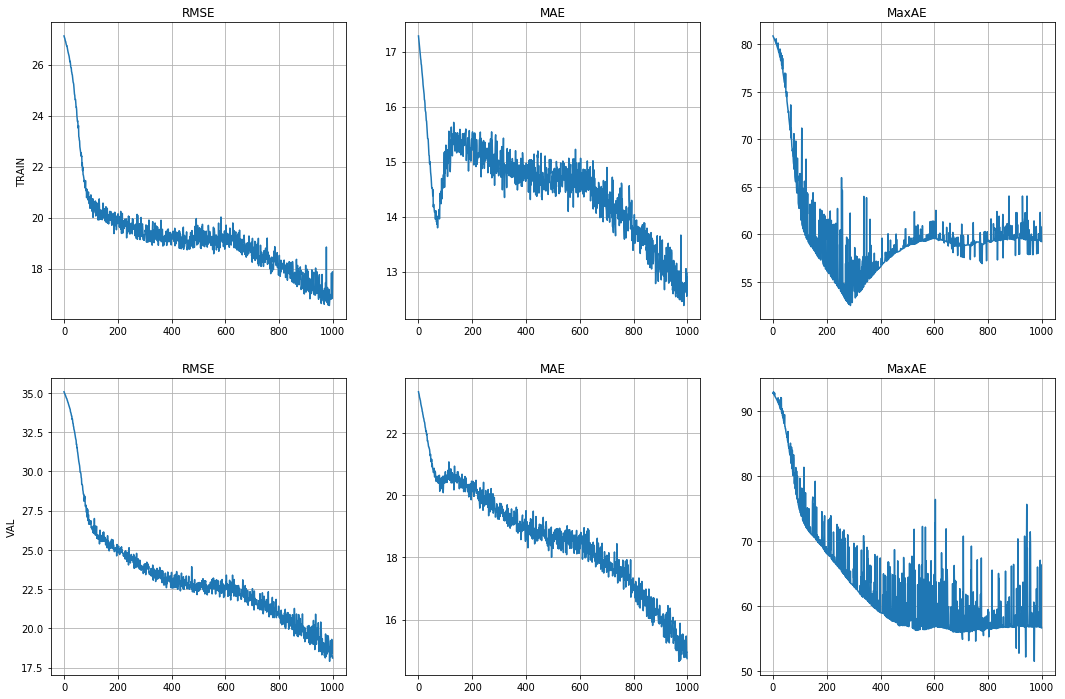

In [37]:
f, ax = plt.subplots(2, 3, figsize=(18, 12))
n_epochs = params['n_epochs']

names = ['RMSE', 'MAE', 'MaxAE']

for i in range(3):
    ax[0, i].plot(np.arange(n_epochs), np.array(logs['train'])[:, i])
    ax[0, i].grid()
    ax[0, i].set_title(names[i])

for i in range(3):
    ax[1, i].plot(np.arange(n_epochs), np.array(logs['val'])[:, i])
    ax[1, i].grid()
    ax[1, i].set_title(names[i])

ax[0, 0].set_ylabel('TRAIN')
ax[1, 0].set_ylabel('VAL')

plt.show()

In [44]:

params = {
    'model': net,
    'criterion': criterion,
    'dataloaders': dataloaders,
    'acquisition_fun': random_sampling,
    'optimizer': optimizer,
    'n_epochs': 15,
    'n_val': 5,
    'new_point_size': 5
}


In [46]:
net, logs = active_train_model(**params)

--------------------
Training complete in 0 mins 1 seconds with 15 epoch


Testing model: 100%|██████████| 100/100 [00:00<00:00, 46942.41it/s]


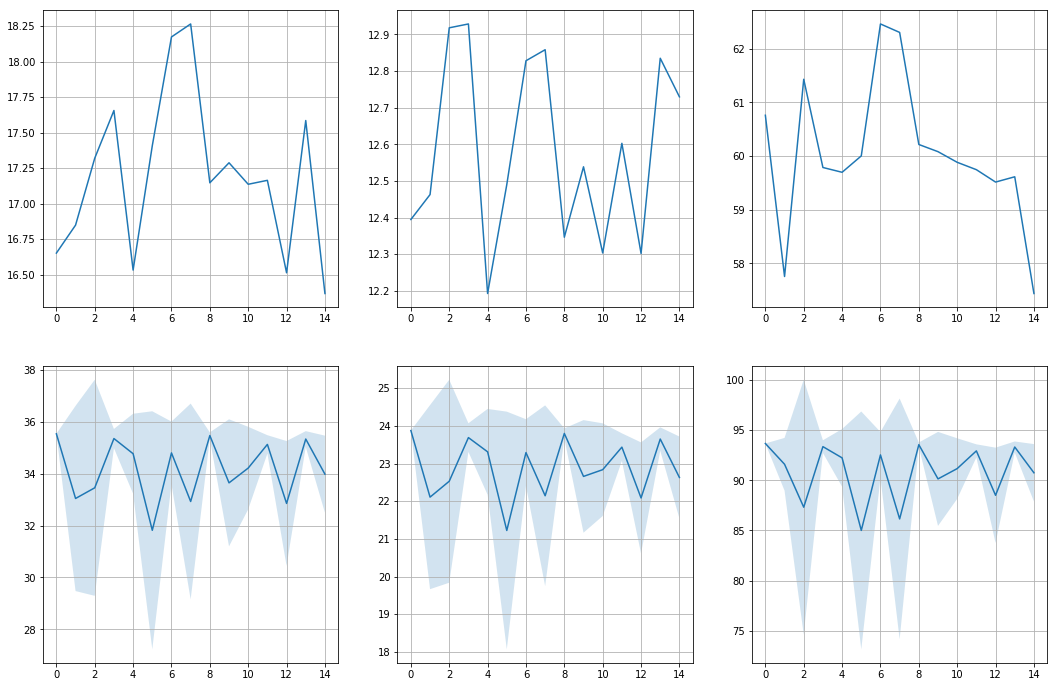

In [49]:
f, ax = plt.subplots(2, 3, figsize=(18, 12))
num_epoch = 15

for i in range(3):
    ax[0, i].plot(np.arange(num_epoch), np.array(logs['train'])[:, i])
    ax[0, i].grid()

for i in range(3):
    mean = np.array(logs['val'])[:, :, i].mean(axis=1)
    std = np.array(logs['val'])[:, :, i].std(axis=1)
    ax[1, i].plot(np.arange(num_epoch), mean)
    ax[1, i].fill_between(np.arange(num_epoch), mean-std, mean+std, alpha=0.2)
    ax[1, i].grid()
